# Sizing a CSTR for Multiple Reactions

Find the residence time for a CSTR to convert 0.95 of the limiting reactant in the reaction network 

$$A + B \rightarrow C\\
C + 2B \rightarrow D$$

The network has four components and two reactions. The corresponding rate laws are

$$r_1 = k_1 C_A C_B  \\
r_2 = k_2 C_B^2 C_C$$

where the rate constants $k_1$ = 0.15 L/mol/min and $k_2$ = 0.1 L$^2$/mol$^2$/min
have been formulated using 1 mol C as a basis.


The design equations for a CSTR are

$$\frac{C_A - C_{A0}}{\tau} = r_A = \sum_j \nu_{ij}r_j$$

where
$C_i$ is the concentration of species $i$,
$\tau$ is the residence time,
$r_i$ is the rate of generation of species $i$,
$\nu_{ij}$ is the stoichiometric coefficient of species $i$ in reaction $j$,
and
$r_j$ is the rate of reaction $j$.

The four resulting equations must be solved simultaneously:

$$
\begin{aligned}
  \frac{C_A-C_{A0}}{\tau} &= r_A = -r_1  \\
  \frac{C_B-C_{B0}}{\tau} &= r_B = -r_1 -2r_2  \\
  \frac{C_C-C_{C0}}{\tau} &= r_C = r_1 - r_2  \\
  \frac{C_D-C_{D0}}{\tau} &= r_D = r_2
\end{aligned}
$$

The inlet molar flow rates are $C_{A0}$ = 10 M and $C_{B0}$ = 3 M.

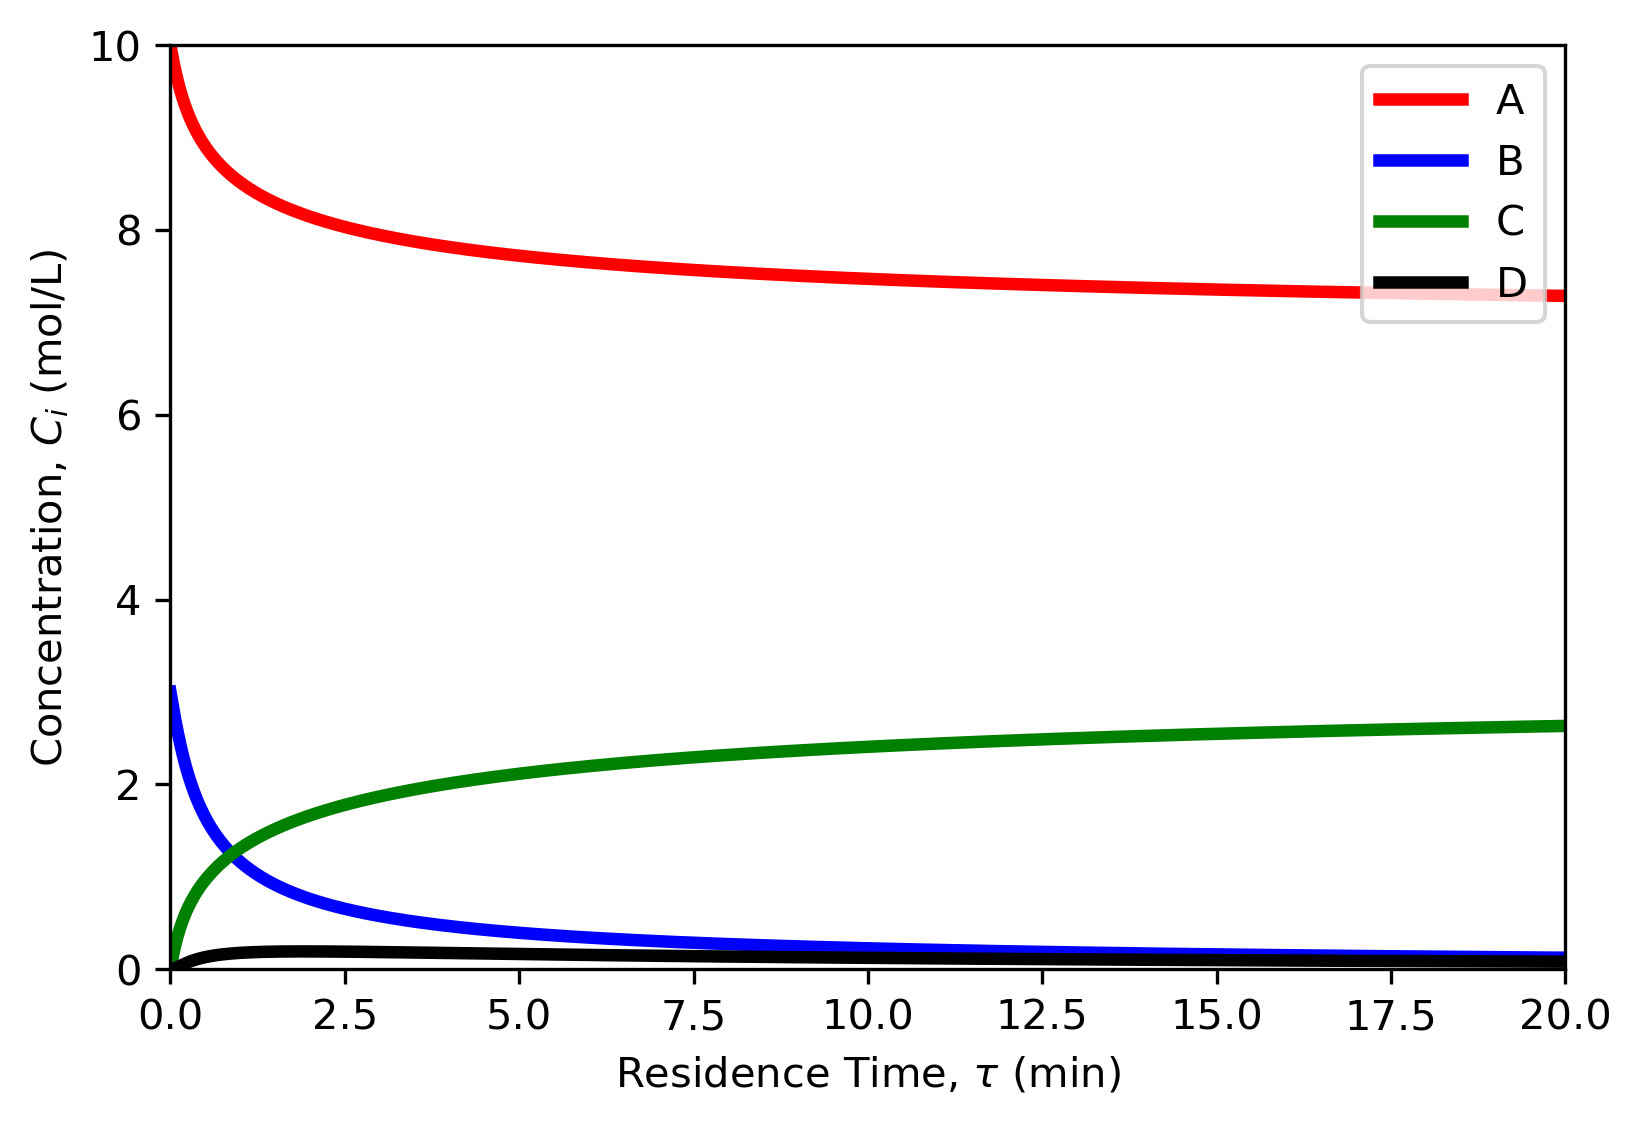

In [1]:
################################################################################
# IMPORT MODULES
################################################################################
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

################################################################################
# DEFINE CONSTANTS
################################################################################
# Internal Units
# Length: m
# Mass: kg
# Time: s
# Temperature: K
# Amount: mol

# universal constants
Rg = 8.314 # J/mol/K

# unit conversions
hr_to_s = 3600.
min_to_s = 60.
s_to_min = 1/60.
k_to_u = 1000.
L_to_m3 = 1.e-3
m3_to_L = 1.e3

# reactions
nRxns = 2
nSpecies = 4

# stoichiometry
nu = np.zeros((nRxns,nSpecies))
nu[0] = np.array([-1, -1,  1,  0]) # 1 mol C basis
nu[1] = np.array([ 0, -2, -1,  1]) # 1 mol C basis
k = np.array([0.15 * L_to_m3/min_to_s,
              0.1  * L_to_m3**2/min_to_s])

# feed conditions
C0 = np.array([10,3,0,0]) / L_to_m3 # mol/m^3

# reactor parameters
tMax = 20 * min_to_s # s
XBMax = 0.95

################################################################################
# DEFINE FUNCTIONS
################################################################################
def rxns(Ci,ti):
    CA,CB,CC,CD = Ci
    r_rxn = np.array([k[0]*CA*CB,
                      k[1]*CB**2*CC])
    r_gen = [np.dot(nu[:,i],r_rxn) for i in range(nSpecies)]
    res = (Ci-C0)/ti - r_gen
    return res

################################################################################
# FILE MANAGEMENT
################################################################################
# create output files
pngFile = '35_cstr_%s.png'

################################################################################
# MAIN CODE
################################################################################
# independent variable
nPts = 1000
t = np.linspace(0,tMax,nPts)

# solve the eqns
C = np.zeros((nSpecies,nPts))
C[:,0] = C0
for i,ti in enumerate(t):
    if i == 0:
        continue
    C[:,i] = opt.root(rxns,C[:,i-1],ti).x
CA,CB,CC,CD = C

# plot the results
plt.figure(figsize=(6,4),dpi=300)
plt.plot(t*s_to_min,CA/m3_to_L,'r-',lw=3,label='A')
plt.plot(t*s_to_min,CB/m3_to_L,'b-',lw=3,label='B')
plt.plot(t*s_to_min,CC/m3_to_L,'g-',lw=3,label='C')
plt.plot(t*s_to_min,CD/m3_to_L,'k-',lw=3,label='D')
plt.xlabel(r'Residence Time, $\tau$ (min)')
plt.xlim(0,tMax*s_to_min)
plt.ylabel('Concentration, $C_i$ (mol/L)')
plt.ylim(0,np.max(C)/m3_to_L)
plt.legend(loc='upper right')
plt.savefig(pngFile % 'concentrations')

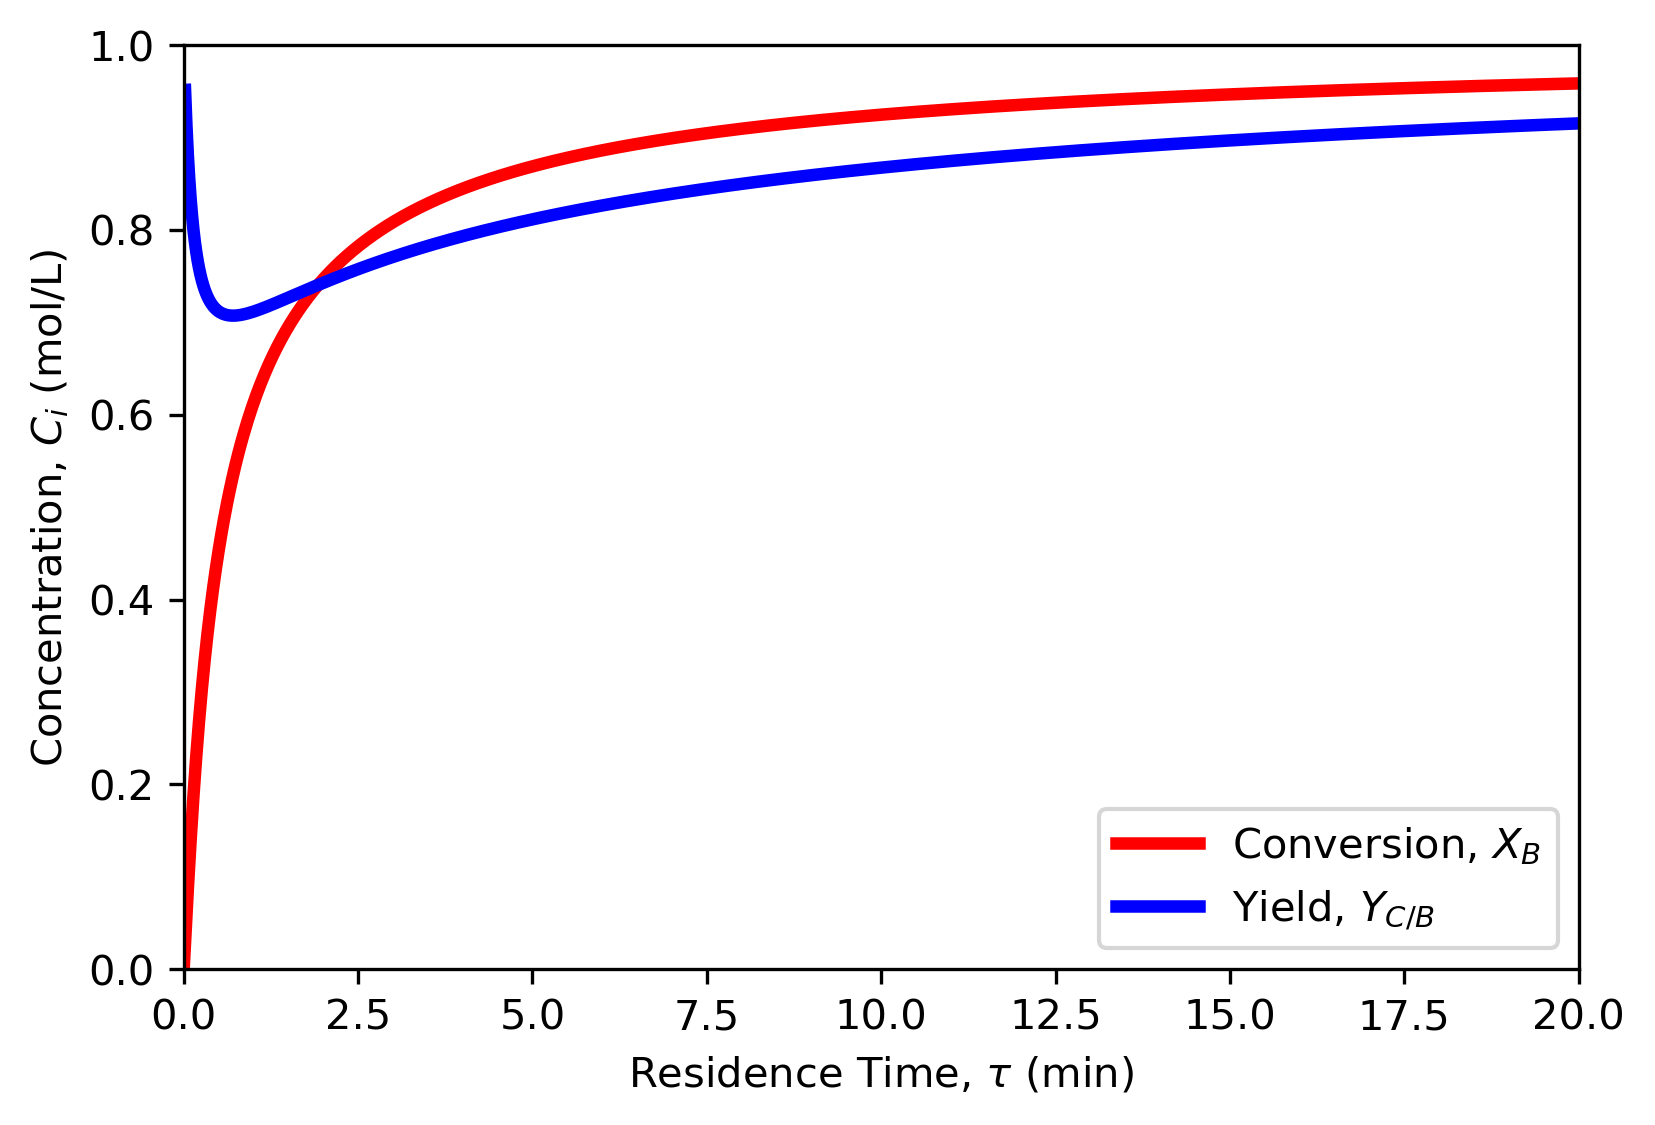

In [2]:
XB = 1 - CB/CB[0]
YCB = CC[1:]/(CB[0] - CB[1:])

# plot the results
plt.figure(figsize=(6,4),dpi=300)
plt.plot(t*s_to_min,XB,'r-',lw=3,label='Conversion, $X_B$')
plt.plot(t[1:]*s_to_min,YCB,'b-',lw=3,label='Yield, $Y_{C/B}$')
plt.xlabel(r'Residence Time, $\tau$ (min)')
plt.xlim(0,tMax*s_to_min)
plt.ylabel('Concentration, $C_i$ (mol/L)')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.savefig(pngFile % 'conversion')

In [3]:
i = np.argmin((XB-XBMax)**2)

print('Output:')
print('  Conversion, XB = %.2f' % (XB[i]))
print('  Residence time, tau = %.1f min' % (t[i]/min_to_s))
print('  Concentrations:')
print('    CA = %.3f mol/L' % (CA[i]*L_to_m3))
print('    CB = %.3f mol/L' % (CB[i]*L_to_m3))
print('    CC = %.3f mol/L' % (CC[i]*L_to_m3))
print('    CD = %.3f mol/L' % (CD[i]*L_to_m3))
print('  Selectivity, CC/CD = %.1f' % (CC[i]/CD[i]))
print('  Yield, Y_C/B = %.1f' % (CC[i]/(C0[1]-CB[i])))

Output:
  Conversion, XB = 0.95
  Residence time, tau = 16.1 min
  Concentrations:
    CA = 7.337 mol/L
    CB = 0.150 mol/L
    CC = 2.570 mol/L
    CD = 0.093 mol/L
  Selectivity, CC/CD = 27.5
  Yield, Y_C/B = 0.9
